In [1]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')
#make compatible with Python 2 and Python 3
from __future__ import print_function, division, absolute_import 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
Hourly = pd.read_csv('~/Desktop/data-x-data/ProcessedData/House1/House1_1h.csv',parse_dates = True,index_col =0)

In [4]:
Hourly.head(2)

,Fridge,Dryer,Coffee machine,Kettle,Washing machine,PC,Freezer,Total
2012-06-01 00:00:00,58741.58480,228569.30894,0.0,0.0,17787.55550,115539.1821,78656.50086,499294.13220
2012-06-01 01:00:00,28474.21582,2032.87680,0.0,0.0,17663.64367,52521.8472,49270.74354,149963.32703


In [5]:
series = Hourly['Fridge']

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [7]:
#Define function to test stationairty of data
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

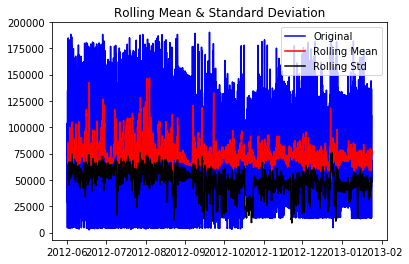

Results of Dickey-Fuller Test:
Test Statistic                -1.019063e+01
p-value                        6.336149e-18
#Lags Used                     3.200000e+01
Number of Observations Used    5.655000e+03
Critical Value (1%)           -3.431507e+00
Critical Value (5%)           -2.862051e+00
Critical Value (10%)          -2.567042e+00
dtype: float64


In [8]:
test_stationarity(series)

In [9]:
#Calculates ACF & PACF
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(series, nlags=20)
lag_pacf = pacf(series, nlags=20, method='ols')

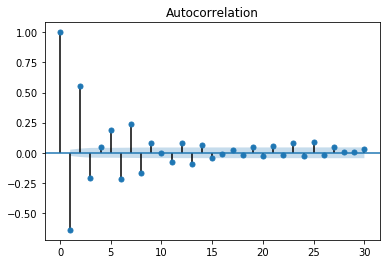

In [10]:
#Plot ACF
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools
import statsmodels.graphics.tsaplots
fig_acf = statsmodels.graphics.tsaplots.plot_acf(series, lags=30)

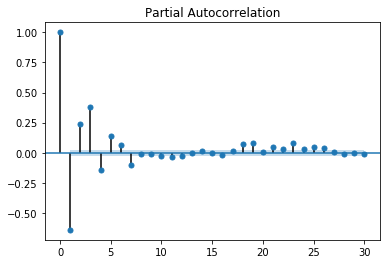

In [11]:
#Plot PACF
fig_pcaf = statsmodels.graphics.tsaplots.plot_pacf(series, lags=30)

In [12]:
# Test whether we should difference at the alpha=0.05 significance level
from pyramid.arima.stationarity import ADFTest

adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.is_stationary(series)
print(p_val, should_diff)

0.99 False


In [13]:
# Test whether we should difference using differnet criteria
from pyramid.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(series, test='adf')  # -> 0
print(n_adf)
# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(series, test='kpss')  # -> 0
print(n_kpss)
# Or a PP test:
n_pp = ndiffs(series, test='pp')  # -> 0
print(n_pp)

#assert n_adf == n_kpss == n_pp == 0

0
1
0


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                 Fridge   No. Observations:                 5688
Model:                     ARMA(4, 3)   Log Likelihood              -67345.303
Method:                       css-mle   S.D. of innovations          33551.441
Date:                Fri, 07 Dec 2018   AIC                         134708.607
Time:                        00:11:43   BIC                         134768.422
Sample:                    06-01-2012   HQIC                        134729.435
                         - 01-23-2013                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         7.555e+04    596.025    126.754      0.000    7.44e+04    7.67e+04
ar.L1.Fridge    -0.8210      0.074    -11.071      0.000      -0.966      -0.676
ar.L2.Fridge     0.3132      0.068      4.62

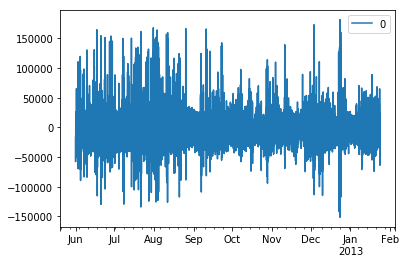

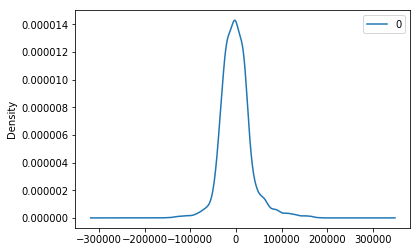

                   0
count    5688.000000
mean       -5.087315
std     33557.004653
min   -151515.117437
25%    -20257.645790
50%     -2217.393499
75%     16263.779324
max    181598.661770


In [14]:
#Build Arima model on Fridge energy consumption, test on (p,d,q) orders
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(4,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [15]:
# Build rolling arima model & make predictions
X = series.values
size = int(len(X) * 0.98)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,0,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


#calculate mean absolute error
mean_absolute_error(test, predictions)

predicted=19446.644691, expected=14069.863640
predicted=117561.529576, expected=136669.620780
predicted=30100.267490, expected=16836.464320
predicted=105886.010179, expected=76295.414560
predicted=74463.106789, expected=72886.361120
predicted=50072.045423, expected=100081.434680
predicted=73248.490999, expected=64162.866760
predicted=88785.288183, expected=14512.468440
predicted=100549.859464, expected=137376.382740
predicted=14851.340596, expected=14005.707440
predicted=125458.239880, expected=123005.554560
predicted=39832.267517, expected=31667.769760
predicted=91714.485757, expected=66093.584120
predicted=85818.672514, expected=91058.039680
predicted=40776.278845, expected=13952.243940
predicted=119152.613822, expected=139313.000640
predicted=17704.254133, expected=14213.145820
predicted=115014.535836, expected=97312.461520
predicted=61563.120923, expected=54353.873520
predicted=66226.270817, expected=20800.747580
predicted=111786.217876, expected=132902.843080
predicted=8635.646756

20326.718399824727

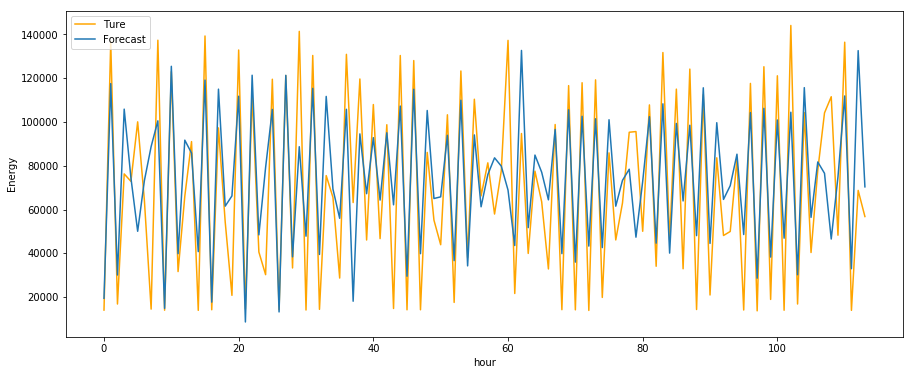

In [16]:
# plot predicted values and true values against time
plt.rcParams['figure.figsize'] = (15, 6)
fig, ax = plt.subplots()

ax.plot(X[size:len(X)],color='orange', linestyle='-', label='Ture')
ax.plot(predictions, linestyle='-', label = 'Forecast')
ax.set_xlabel('hour') # add xlabel
ax.set_ylabel('Energy') # add xlabel

ax.legend(loc=2) # location of legend is an integer, 

In [17]:
#Define function to calculate mean absolute percentage error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [18]:
#Calculate mean absolute percentage error
forecast = np.concatenate(predictions, axis=0)
mean_absolute_percentage_error(test, forecast)

0.5752453827834234

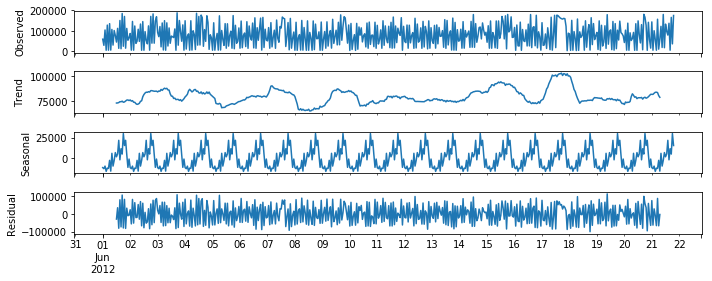

In [21]:
#Get a subset of first 500 hours of Fridge energy consumption
small = series[:500]
#Decompose the subset to study components of data
plt.rcParams['figure.figsize'] = (10, 4)
from plotly.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(small,model='additive')
fig = result.plot()
#Find seasonal component, seanson = 24 hours(1 day)
